In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import curve_fit
import math
import pandas as pd
from IPython.display import display, HTML
import pyabf

# written by Dongwook (Danny) Lim 
# Date updated: 05/02/2023

In [10]:
# Gaussian function
def gaussian(x, O_p, R_n, R_p, R_0, sigma, sigma2):
    y = R_0 + R_p*(np.exp(-((x-O_p)**2)/(2*sigma**2))) + R_n*(np.exp(-((x-O_p+180)**2)/(2*sigma2**2)))
    return y
    
def remove_outlier(arr):
    # IQR
    Q1 = np.percentile(arr, 25,
                       interpolation = 'midpoint')
    Q3 = np.percentile(arr, 75,
                       interpolation = 'midpoint')
    IQR = Q3 - Q1
    # Upper bound
    upper=Q3+1.5*IQR
    # Lower bound
    lower=Q1-1.5*IQR
    return arr[np.where((arr<upper)&(arr>lower))]


def find_upper_bound(arr):
    # IQR
    Q1 = np.percentile(arr, 25,
                       interpolation = 'midpoint')
    Q3 = np.percentile(arr, 75,
                       interpolation = 'midpoint')
    IQR = Q3 - Q1
    # Upper bound
    upper=Q3+1.5*IQR
    return upper

def bottom_mean_grey(arr):
    cnt = 0
    arr.sort()
    a = []
    q = 0.3
    for i in range(len(arr)):
        cnt += 1
        if cnt <= half_sec*2*q:
            a.append(arr[i])
    return np.mean(a)

In [11]:
direc = "/Users/dannylim/Downloads/Ethan data/20230413/movie4/suite2p/plane0"#"/Volumes/My Passport for Mac/SampleData_/230214/LA30_7/suite2p/plane0"
fps = 30
sweep_number = 8 

# Load data
f = np.load(direc + "/F.npy")
fneu = np.load(direc + "/Fneu.npy")
iscell = np.load(direc + "/iscell.npy")
spks = np.load(direc + "/spks.npy")
zeroC = scipy.io.loadmat(direc + "/zeroCrossings.mat")["zeroCrossings"].flatten()

# Pre-processing
cellvalue = f - 0.7 * fneu
original_ind = np.where(iscell[:, 0] == 1)[0]
cellFneu = cellvalue[original_ind, :]

angles = [int(360 / (zeroC.shape[0] / 2 / sweep_number)) * i for i in range(int(zeroC.shape[0] / 2 / sweep_number))]
increment = angles[1]
orientations = -np.ones(fneu.shape[1])
orient_dict = dict(zip(angles, [[]] * len(angles)))

for i in range(len(zeroC) // 2):
    startind = zeroC[i * 2]
    endind = zeroC[i * 2 + 1]
    angle = angles[i % len(angles)]
    orientations[startind:endind] = angle
    orient_dict[angle] = orient_dict[angle] + [(startind, endind)]

#plt.plot(orientations)
#plt.show()

print(f.shape, fneu.shape, iscell.shape, spks.shape, zeroC.shape)
print("The number of detected cells is",(iscell==1).sum())
print("The number of increments is", int(zeroC.shape[0]/2/sweep_number))
print("The angle increment is", int(360/(zeroC.shape[0]/2/sweep_number)),"degree")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dannylim/Downloads/Ethan data/20230413/movie4/suite2p/plane0/F.npy'

# Running the Analysis

In [4]:
pull_n = 2









The Orientation Index (OI): 0.18921566
The Direction Index (DI): 1.8819708
The Signal-Noise-Ratio (SNR): -0.10710282


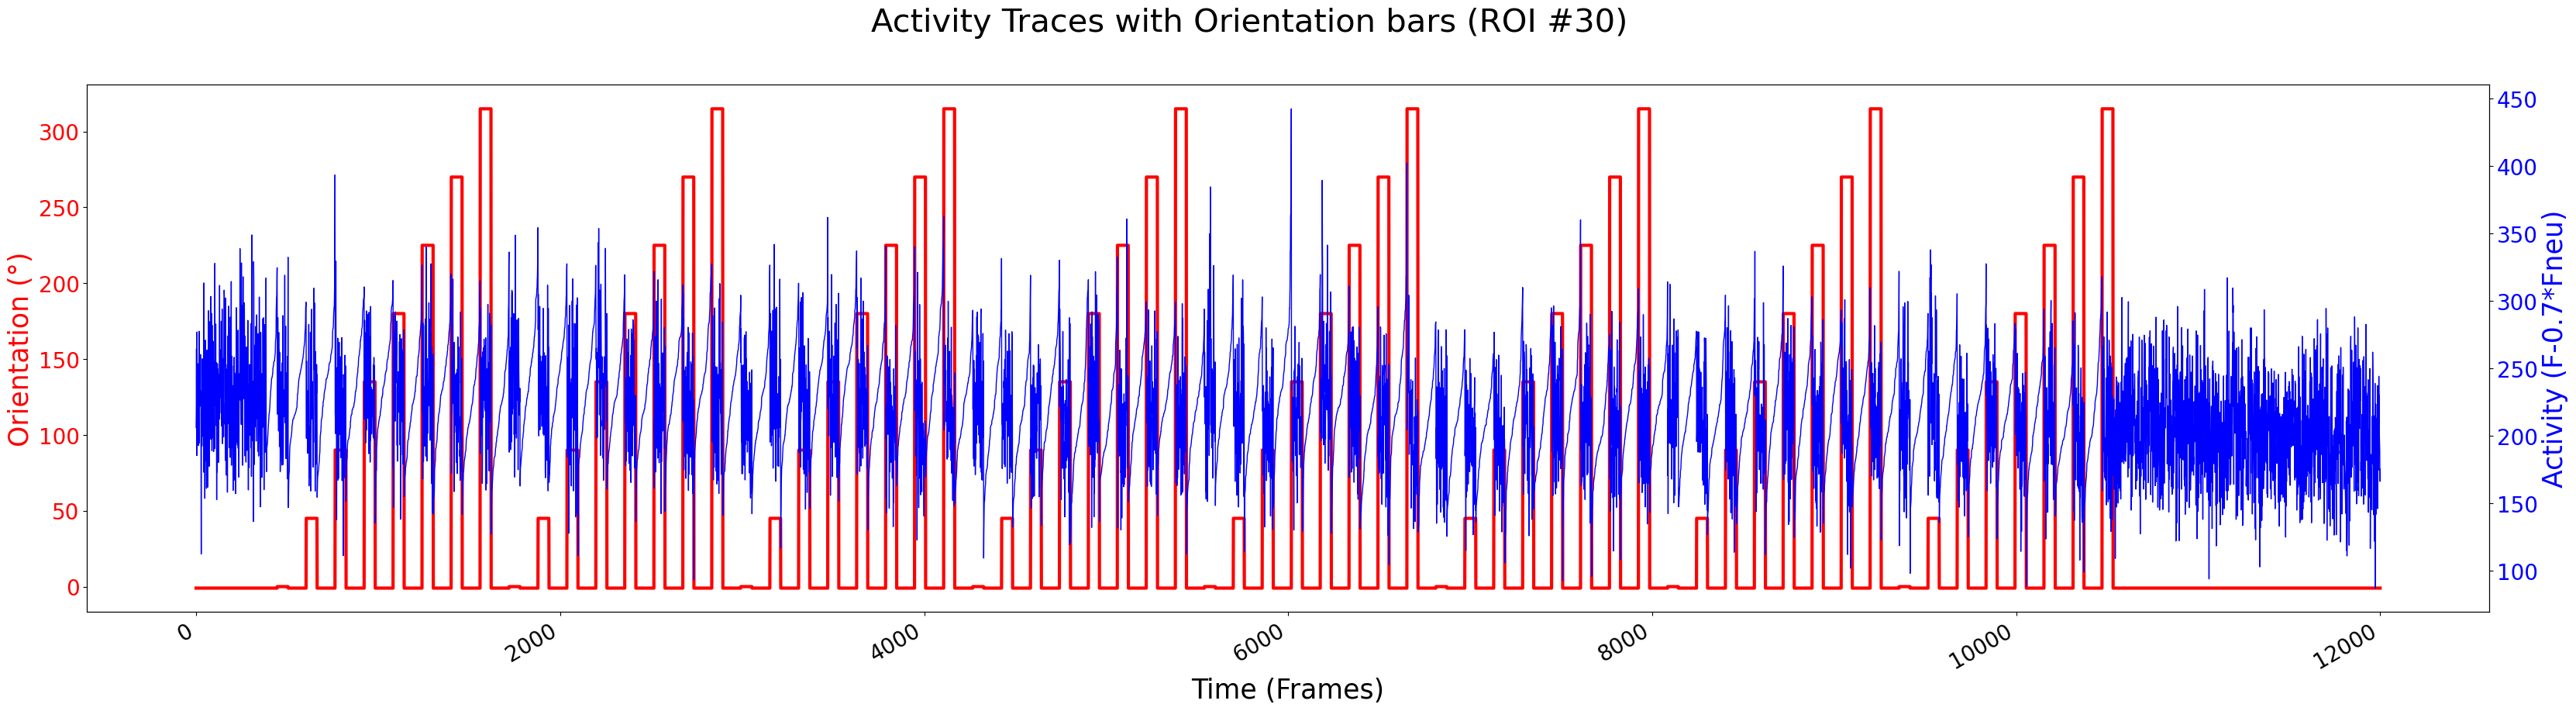

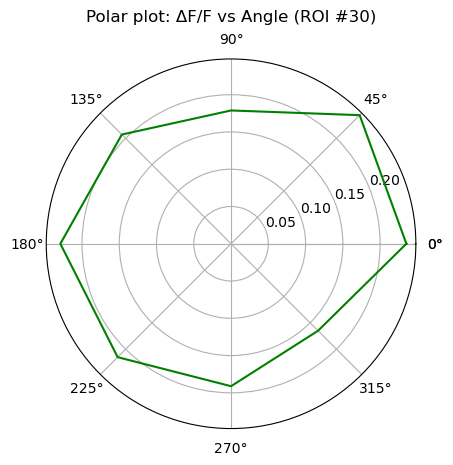

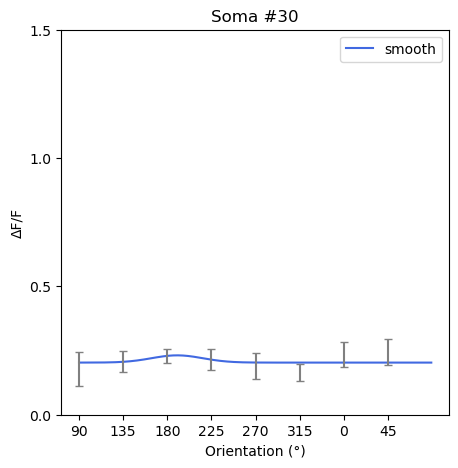

,Preferred Orientation (°),Response at null orientation,Response at preferred orientation,Base_Response,Tuning width at preferred orientation,Tuning width at null orientation,Data std
Activity Fit,189.999474,3.664406e-10,0.028251,2.030951e-01,26.022661,22.500000,0.208906
Spike Fit,212.627112,4.342668e-01,0.906179,1.855711e-22,5.126276,6.535351,0.550335
Mean_ΔF/F Fit,199.760977,1.373651e-01,0.112366,1.138774e-01,90.000000,32.460173,0.071701


In [7]:
activitytrace=True
resultplot=True 
OriActiplot=False
DataFitplot=False
SpikeFitplot=False 
MeanDFF=False

rest_sum = 0
for i in range(zeroC.shape[0]):
    if i % 2 == 0:
        end_rest = zeroC[i] #end_rest
        start_rest = zeroC[i-1] if i != 0 else zeroC[i] - 60 #start_rest
        rest_sum += end_rest-start_rest

half_sec = round(rest_sum/zeroC.shape[0])
# 40 frame = 1 sec

for c in range(30,31): #cellFneu.shape[0]:
    # Grab the target cell
    cell = cellFneu[c, :]
    print("\n\n\n\n=============================================================================================================")
    print("=============================================================================================================")
    print("\n\n\n")

    # Calculate angle rests
    angle_rests = dict(zip(angles, [[]] * len(angles)))
    angle_spike_rests = dict(zip(angles, [[]] * len(angles)))
    for batch in range(sweep_number):
        starting_index = batch * (2*len(angles))
        for orient in range(len(angles)):
            i = starting_index + orient * 2
            from_ind = zeroC[i - 1] if i!= 0 else zeroC[i] - 60 #from_ind: indices of where the grey starts
            to_ind = zeroC[i] #to_ind: indices of where the grey ends
            #angle_rests[angles[orient]] = angle_rests[angles[orient]] + [cell[from_ind:to_ind].mean()] #using 1 sec (full grey) of the grey background
            #angle_rests[angles[orient]] = angle_rests[angles[orient]] + [cell[from_ind+half_sec:to_ind].mean()] #using 0.5 sec (last half) of the grey background
            angle_rests[angles[orient]] = angle_rests[angles[orient]] + [bottom_mean_grey(cell[from_ind:to_ind])] #using the bottom percentile of the grey background 
            angle_spike_rests[angles[orient]] = angle_spike_rests[angles[orient]] + [spks[c][from_ind+half_sec:to_ind].mean()]
            
    # Calculate angle_vals and angle_means
    angle_vals = dict(zip(angles, [[]] * len(angles))) # the # of angles subarrays, each angle subarray has the # of sweeps subarrays
    angle_vals_ = dict(zip(angles, [[]] * len(angles))) # the # of angles subarrays, all sweep samples in each subarray
    angle_means = {}
    spikes = dict(zip(angles, [[]]*len(angles)))
    xspike, yspike = [], []
    engles = dict(zip(angles,[[]]*len(angles)))
    xengle, yengle = [], []
    for angle in angles:
        tot = 0
        ct = 0
        for sweep, idxs in enumerate(orient_dict[angle]):
            tot += cell[idxs[0]:idxs[1]].sum()
            ct += idxs[1] - idxs[0]
            angle_vals_[angle] = angle_vals_[angle] + [list(cell[idxs[0]:idxs[1]])]
            angle_vals[angle] = angle_vals[angle] + list(cell[idxs[0]:idxs[1]])
            ########
            spk = (np.mean(spks[c][idxs[0]:idxs[1]])-angle_spike_rests[angle][sweep])/((idxs[1]-idxs[0])/fps) #noise subtraction for spkie values
            spikes[angle] = spikes[angle] + [spk]
            xspike.append(angle)
            yspike.append(spk)
            #####################################################################################################
            engle = (np.mean(cellvalue[c][idxs[0]:idxs[1]])-angle_rests[angle][sweep])/angle_rests[angle][sweep]
            engles[angle] = engles[angle] + [engle]
            xengle.append(angle)
            yengle.append(engle)
            #####################################################################################################
        angle_means[angle] = tot / ct
        for batch in range(sweep_number):
            batch_vals = angle_vals_[angle][batch]
            angle_vals_[angle][batch] = (np.array(batch_vals)-angle_rests[angle][batch]) / angle_rests[angle][batch]  # normalize
    xspike = np.array(xspike)
    xengle = np.array(xengle)
    
    
    # Prepare data for fitting
    ydata = np.concatenate([np.concatenate(angle_vals_[angle]) for angle in angles[pull_n:]] + [np.concatenate(angle_vals_[angle]) for angle in angles[:pull_n]])
    
    xdata = np.array([angle for angle in angles[pull_n:] for j in range(len(np.concatenate(angle_vals_[angle])))] + [angle+360 for angle in angles[:pull_n] for j in range(len(np.concatenate(angle_vals_[angle])))])
    
    
    all_samples = [np.concatenate(angle_vals_[angle]) for angle in angles]
    ymeans = [np.concatenate(angle_vals_[angle]).mean() for angle in angles]
    OS_SE = [np.concatenate(angle_vals_[angle]).std() for angle in angles]
    y_original_means = [np.mean(angle_vals[angle]) for angle in angles]
    y_original = np.concatenate([angle_vals[angle] for angle in angles])
    ysigma = ydata.std()
    xsigma = xdata.std()
    ymax = ydata.max()
    ymin = min([i for i in ydata if i > 0])

    #Calculating the indices for OI and DI
    half_angles = int(len(angles)/2) #180 degrees in indice for calculating null index
    steps_ortho = int(len(ymeans)/4) #90 degrees in indice for calculating orthogoanl index
    max_ind=0
    ortho_ind_plus=0
    ortho_ind_minus=0
    null_ind = 0
    for i in range(len(ymeans)):
        if ymeans[i] == max(ymeans):
            max_ind = i
            ortho_ind_plus = i+steps_ortho if i+steps_ortho < len(ymeans) else i+steps_ortho-len(ymeans)
            ortho_ind_minus = i+steps_ortho*3 if i+steps_ortho*3 < len(ymeans) else i+(steps_ortho*3)-len(ymeans)
            null_ind = i+half_angles if i+half_angles < len(ymeans) else i+half_angles-len(ymeans)

    # Orientation Index (based on the paper, doi: 10.3389/fncir.2014.00092)  
    OI = ((ymeans[max_ind]+ymeans[null_ind])-(ymeans[ortho_ind_plus]+ymeans[ortho_ind_minus]))/(ymeans[max_ind]+ymeans[null_ind])
    print("The Orientation Index (OI):", OI)

    #Direction Index
    DI = (ymeans[max_ind]+ymeans[null_ind])/ymeans[max_ind]
    print("The Direction Index (DI):",DI)
    
    #Signal-Noise-Ratio
    SNR = (ymeans[i]-ymeans[ortho_ind_plus])/(OS_SE[i]+OS_SE[ortho_ind_plus])
    print("The Signal-Noise-Ratio (SNR):",SNR)
    
    #True OSI (Orientation-Selectivity-Index)
#     x = O_p+90
#     if x > 360: x=x-360
#     R_ortho_pos = R_0 + R_p * np.exp(-((x- O_p) ** 2) / (2 * sigma ** 2)) + R_n * np.exp(-((x - O_p+180) ** 2) / (2 * sigma2 ** 2))
#     x = O_p+270
#     if x > 360: x=x-360
#     R_ortho_neg = R_0 + R_p * np.exp(-((x- O_p) ** 2) / (2 * sigma ** 2)) + R_n * np.exp(-((x - O_p+180) ** 2) / (2 * sigma2 ** 2))
#     R_ortho = (R_ortho_pos+R_ortho_neg)/2
#     OSI = (R_p-R_ortho)/(R_p+R_ortho)
#     print("Orientation Selectivity Index:",OSI)
    
    #True DSI (Direction-Selectivity-Index)
#     DSI = (R_p-R_n)/(R_p+R_n)
#     print("Direction Selectivity Index:",DSI)
    
#     no_ol_samples = [remove_outlier(samples) for samples in all_samples]
#     ydata_ = np.concatenate(no_ol_samples)
#     xdata_ = np.array([angles[i] for i in range(len(angles)) for _ in range(len(no_ol_samples[i]))])
    top_ub = max([find_upper_bound(samples) for samples in all_samples])
    
######################################          FITTING             ############################################
    
    # Fit the gaussian function for Activity
    parameters, _ = curve_fit(gaussian, xdata, ydata,
                              bounds=([xdata.min(),0,0,-ymax,increment/2,increment/2], 
                                      [xdata.max()+increment, top_ub, top_ub, ymax, increment, increment]), 
                              maxfev=10000, method = 'trf')
    O_p, R_n, R_p, R_0, sigma, sigma2 = parameters

    # Fit the gaussian function for Spikes
    yspike_max, yspike_std = max(yspike), np.array(yspike).std()
    parameters, _ = curve_fit(gaussian, xspike, yspike, bounds=(0, [xdata.max()+increment, yspike_max*3, yspike_max*3, yspike_max, increment/2, increment]), maxfev=2000)
    O_p_s, R_n_s, R_p_s, R_0_s, sigma_s, sigma2_s = parameters

    # Fit the gaussian function for Activity without outliers
    #parameters, _ = curve_fit(gaussian, xdata_, ydata_, bounds=([0,0,0,0,10,10], [360, 2, 2, 2, increment*2, increment*4]), maxfev=2000)
    #O_p_ol, R_n_ol, R_p_ol, R_0_ol, sigma_ol, sigma2_ol = parameters    

    # Fit the gaussian function for Engles
    yengle_max, yengle_std = max(yengle), np.array(yengle).std()
    parameters, _ = curve_fit(gaussian, xengle, yengle, bounds=(0, [360, yengle_max*4, yengle_max*4, yengle_max, increment*2, increment*4]), maxfev=2000)
    O_p_e, R_n_e, R_p_e, R_0_e, sigma_e, sigma2_e = parameters
    
    #Forcing the highest peak to be Preferred Orientation
#     temp_O_p = O_p
#     temp_O_n = O_n
#     temp_R_p = R_p
#     temp_R_n = R_n
#     if R_n > R_p:
#         R_p = R_n
#         R_n = temp_R_p
#         O_p = O_p-180 if O_p-180 > 0 and O_p-180<360 else O_p + 180
#         O_n = O_p +180 if O_n-180 > 0 and O_n-180<360 else O_n + 180


    if R_p >= R_n:
        fit_result = pd.DataFrame({"Preferred Orientation (°)":[O_p], 
                                   "Response at null orientation": [R_n], 
                                   "Response at preferred orientation": [R_p], 
                                   "Base_Response": [R_0], 
                                   "Tuning width at preferred orientation": [sigma], 
                                   "Tuning width at null orientation": [sigma2], 
                                   "Data std":[ysigma]},
                                 index=["Activity Fit"])
    else: # R_n > R_p
        fit_result = pd.DataFrame({"Preferred Orientation (°)":[(O_p+180)%360], 
                               "Response at null orientation": [R_p], 
                               "Response at preferred orientation": [R_n], 
                               "Base_Response": [R_0], 
                               "Tuning width at preferred orientation": [sigma], 
                               "Tuning width at null orientation": [sigma2], 
                               "Data std":[ysigma]},
                             index=["Activity Fit"])
    #fit_result.loc["Activity Fit without OL"] = [O_p_ol, R_n_ol, R_p_ol, R_0_ol, sigma_ol, sigma2_ol, ydata_.std()]
    fit_result.loc["Spike Fit"] = [O_p_s, R_n_s, R_p_s, R_0_s, sigma_s, sigma2_s, yspike_std]
    fit_result.loc["Mean_ΔF/F Fit"] = [O_p_e, R_n_e, R_p_e, R_0_e, sigma_e, sigma2_e, yengle_std]
    
    angle_stds, angle_means, angle_Sstds, angle_Smeans = [], [], [], []
    for angle in angles:
        big_sample = np.concatenate(angle_vals_[angle])
        angle_means.append(big_sample.mean())
        angle_stds.append(big_sample.std())
        angle_samples = np.array([sample.mean() for sample in angle_vals_[angle]])
        angle_Sstds.append(angle_samples.std())
        angle_Smeans.append(angle_samples.mean())            
            
    r = ymeans + [ymeans[0]]
    data_theta = [math.radians(i) for i in angles] + [math.radians(angles[0])]
    
###################################           PLOTTING                   #######################################  
   
    # plot here    
    if activitytrace:
        color_orient = "red"
        color_cell = "blue"
        fsize=(40,10)
        
        # Plot activity traces with orientation bars
        fig, ax1 = plt.subplots(figsize=fsize)
        ax2 = ax1.twinx()

        ax1.plot(orientations, color=color_orient, lw=3)
        ax2.plot(cell, color=color_cell, lw=1)

        ax1.set_xlabel("Time (Frames)", fontsize=25)
        ax1.tick_params(axis="x", labelsize=20)

        ax1.set_ylabel("Orientation (°)", color=color_orient, fontsize=25)
        ax1.tick_params(axis="y", labelcolor=color_orient, labelsize=20)

        ax2.set_ylabel("Activity (F-0.7*Fneu)", color=color_cell, fontsize=25)
        ax2.tick_params(axis="y", labelcolor=color_cell, labelsize=20)

        fig.suptitle("Activity Traces with Orientation bars (ROI #" + str(original_ind[c]) + ")", fontsize=30)
        fig.autofmt_xdate()
        plt.show()

        
    if resultplot:   
        #polar plot
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.plot(data_theta, np.array(r), color='g', linewidth=1.5)
        ax.grid(True)
        ax.set_title("Polar plot: ΔF/F vs Angle (ROI #" + str(original_ind[c]) + ")", va='bottom')
        ax.set_xticks(data_theta)
        plt.show()

        # fit curve with SEM error bars
        new_angles = np.unique(xdata)
        
        plt.figure(figsize=(5,5))
        plt.plot(range(xdata.min(), xdata.max()+increment, 1), gaussian(range(xdata.min(), xdata.max()+increment, 1), O_p, R_n, R_p, R_0, sigma, sigma2), color="royalblue", label="smooth")
        plt.errorbar(new_angles, np.array(angle_Smeans[pull_n:] + angle_Smeans[:pull_n]), yerr=1.96* np.array(angle_Sstds)/np.sqrt(sweep_number), capsize=3, color="grey", ls='none')
        plt.legend()
        plt.xticks(new_angles, labels=angles[pull_n:] + angles[:pull_n])
        plt.yticks([0, 0.5, 1.0, 1.5])
        plt.xlabel('Orientation (°)')
        plt.ylabel('ΔF/F') 
        plt.title("Soma #" + str(original_ind[c])+"") #second, SEM, 8 values out of 8 samples from each angle
        plt.show()

        # fit curve with SEM error bars (fitted wihout Outliers)
#         plt.figure(figsize=(5,5))
#         plt.plot(range(xdata_.min(), xdata_.max(), 1), gaussian(range(xdata_.min(), xdata_.max(), 1), O_p_ol, R_n_ol, R_p_ol, R_0_ol, sigma_ol, sigma2_ol), color="royalblue", label="smooth")
#         plt.errorbar(angles, np.array(angle_Smeans), yerr=1.96* np.array(angle_Sstds)/np.sqrt(sweep_number), capsize=3, color="grey", ls='none')
#         plt.legend()
#         plt.xticks(angles)
#         plt.yticks([0, 0.5, 1.0, 1.5])
#         plt.xlabel('Orientation (°)')
#         plt.ylabel('ΔF/F') 
#         plt.title("Soma #" + str(original_ind[c])+"") #second, SEM, 8 values out of 8 samples from each angle
#         plt.show()
        
    
    if OriActiplot:     
        fsize=(10, 4)
        # Plot orientation vs ΔF/F and orientation vs activity
        fig, axs = plt.subplots(1, 2, figsize=fsize)
        axs[0].plot(angles, ymeans)
        axs[0].set_xticks(angles)
        axs[0].set_title("Orientation vs ΔF/F (ROI #" + str(original_ind[c]) + ")")
        axs[0].set_xlabel('Orientation (°)')
        axs[0].set_ylabel('ΔF/F')

        axs[1].plot(angles, y_original_means)
        axs[1].set_xticks(angles)
        axs[1].set_title("Orientation vs Activity (ROI #" + str(original_ind[c]) + ")")
        axs[1].set_xlabel('Orientation (°)')
        axs[1].set_ylabel('Activity (F-0.7*Fneu)')
        plt.show()
        
        
    if DataFitplot:      
        # Plot all samples and fitted model
        plt.figure(figsize=(10,5))
        plt.boxplot(np.array(all_samples, dtype=object), positions=angles, widths=10)
        plt.xlim([-10, max(angles)+10])
        plt.plot(range(xdata.min(), xdata.max(), 1), gaussian(range(xdata.min(), xdata.max(), 1), O_p, R_n, R_p, R_0, sigma, sigma2), color="red", label="smooth")
        plt.plot(angles, ymeans, label="means")
        plt.legend()
        plt.xticks(angles)
        plt.xlabel('Orientation (°)')
        plt.ylabel('ΔF/F') 
        plt.title("Boxplot of ΔF/F (ROI #" + str(original_ind[c]) + ")")
        plt.show()
        
        plt.figure(figsize=(10,5))
        plt.plot(range(xdata.min(), max(angles)+10, 1), gaussian(range(xdata.min(), max(angles)+10, 1), O_p, R_n, R_p, R_0, sigma, sigma2), color="red", label="smooth")
        plt.errorbar(angles, np.array(angle_Smeans), yerr=1.96 * np.array(angle_Sstds) / np.sqrt(sweep_number), capsize=3, color="black")
        plt.scatter(angles, np.array(angle_Smeans), color="black")
        plt.legend()
        plt.xticks(angles)
        plt.xlabel('Orientation (°)')
        plt.ylabel('ΔF/F') 
        plt.title("Fitting Gaussians with Tuning Curves (ROI #" + str(original_ind[c]) + ")")
        plt.show()
    
    if SpikeFitplot:    
        fsize=(10,5)
        # heatmap    
        data = np.transpose(np.array(list(spikes.values())))
        plt.imshow(data, cmap="RdYlGn_r")
        plt.xticks(ticks=range(len(angles)), labels=angles)
        plt.yticks(ticks=range(sweep_number), labels=range(1,sweep_number+1))
        plt.xlabel("Angle")
        plt.ylabel("Sweep")
        plt.colorbar()
        plt.title("Sweep-wise Spike Rate Heatmap (ROI #" + str(original_ind[c]) + ")")
        plt.show()

        plt.scatter(xspike, yspike)
        plt.plot(range(xspike.min(), xspike.max(), 1), gaussian(range(xspike.min(), xspike.max(), 1), O_p_s, R_n_s, R_p_s, R_0_s, sigma_s, sigma2_s), color="red", label="smooth")
        plt.xticks(angles)
        plt.xlabel("Angle")
        plt.ylabel("Spike rate (spikes/s)")
        plt.legend()
        plt.title("Scatter plot of Spike rate (ROI #" + str(original_ind[c]) + ")")
        plt.show()
        
    if MeanDFF:
        fsize=(10,5)
        # heatmap    
        data = np.transpose(np.array(list(engles.values())))
        plt.imshow(data, cmap="RdYlGn_r")
        plt.xticks(ticks=range(len(angles)), labels=angles)
        plt.yticks(ticks=range(sweep_number), labels=range(1,sweep_number+1))
        plt.xlabel("Angle")
        plt.ylabel("Sweep")
        plt.colorbar()
        plt.title("Sweep-wise Mean_ΔF/F Heatmap (ROI #" + str(original_ind[c]) + ")")
        plt.show()

        plt.scatter(xengle, yengle)
        plt.plot(range(xengle.min(), xengle.max(), 1), gaussian(range(xengle.min(), xengle.max(), 1), O_p_s, R_n_s, R_p_s, R_0_s, sigma_s, sigma2_s), color="red", label="smooth")
        plt.xticks(angles)
        plt.xlabel("Angle")
        plt.ylabel("Mean_ΔF/F")
        plt.legend()
        plt.title("Scatter plot of Mean_ΔF/F (ROI #" + str(original_ind[c]) + ")")
        plt.show()
        
        
    display(HTML(fit_result.to_html()))
    

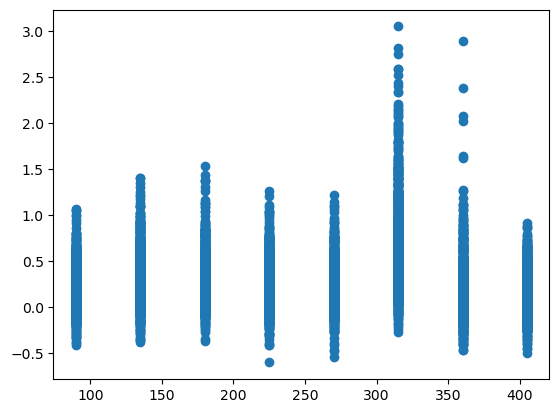

In [46]:
plt.scatter(xdata, ydata)

In [34]:
angles[pull_n:] + angles[:pull_n]

[135, 180, 225, 270, 315, 0, 45, 90]

In [36]:
pull_n

3

In [29]:
angle_Smeans

[0.30209264,
 0.25949514,
 0.26174897,
 0.30989453,
 0.28746867,
 0.2992692,
 0.31417423,
 0.32049853]

In [25]:
len(ydata), len(xdata)
xdata

all_samples

[array([], dtype=float32),
 array([ 0.1429,  0.4484,  0.3102, ...,  0.4518,  0.3007, -0.111 ],
       dtype=float32),
 array([0.1136, 0.3471, 0.4878, ..., 0.0123, 0.2027, 0.093 ], dtype=float32),
 array([ 0.1338,  0.6193,  0.1429, ...,  0.0903, -0.2046, -0.0181],
       dtype=float32),
 array([0.3574, 0.7228, 0.2328, ..., 0.0529, 0.6509, 0.2928], dtype=float32),
 array([ 0.376 ,  0.2832, -0.1122, ...,  0.2647,  0.371 ,  0.2793],
       dtype=float32),
 array([ 0.0155,  0.3107,  0.4851, ...,  0.0354, -0.2036, -0.0017],
       dtype=float32),
 array([ 0.0789,  0.2239, -0.0052, ..., -0.0272,  0.1483,  0.4409],
       dtype=float32)]

In [ ]:
direct = "/Volumes/My Passport for Mac/SampleData_/230405/LA31_2/abf/"
abf = pyabf.ABF(direct + "23405001.abf")
abf.setSweep(0)
plt.plot(abf.sweepX, abf.sweepY)
plt.show()

mat = scipy.io.loadmat(direct + "framestamp.mat")["framestamp"].flatten()
print(np.shape(mat))
length = np.shape(mat)[0]

import scipy.io as sio
mat = sio.loadmat(direct + "framestamp.mat")
mat_load = [[element for element in upperElement] for upperElement in mat['framestamp']] # insert your fieldname here
mat_list = [] # create an empty list
# length = 100 # update with the number of values you want/need...
for i in range(length): # ...or just hardcode it here
    mat_list.append(mat_load[i][0]) # append the values to the list
np_array = np.array(mat_list) # convert the list to a NumPy array
int32_array = np_array.astype(np.int32) # convert values to int32
int32_array # visually confirm that the output is a NumPy array
np.save(direct + "test.npy", int32_array)

In [74]:
direc = "/Volumes/My Passport for Mac/SampleData_/230214/LA30_7/suite2p/plane0"

# Load data
Ops = np.load(direc + "/ops.npy", allow_pickle=True)


type(Ops)

numpy.ndarray

In [35]:
half_angles = int(len(angles)/2) #180 degrees in indice for calculating null index
steps_ortho = int(len(ymeans)/4) #90 degrees in indice for calculating orthogoanl index
max_ind=0
ortho_ind_plus=0
ortho_ind_minus=0
null_ind = 0
for i in range(len(ymeans)):
    if ymeans[i] == max(ymeans):
        max_ind = i
        ortho_ind_plus = i+steps_ortho if i+steps_ortho < len(ymeans) else i+steps_ortho-len(ymeans)
        ortho_ind_minus = i+steps_ortho*3 if i+steps_ortho*3 < len(ymeans) else i+(steps_ortho*3)-len(ymeans)
        null_ind = i+half_angles if i+half_angles < len(ymeans) else i+half_angles-len(ymeans)

print(angles)
print(ymeans)
print(ymeans[max_ind])
print(angles[max_ind]-10)

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
[0.38949347, 0.40672803, 0.4803479, 0.592206, 0.463894, 0.42173022, 0.35847822, 0.33626664, 0.4468459, 0.7387824, 0.39099142, 0.26527202]
0.7387824
260
